[View in Colaboratory](https://colab.research.google.com/github/ocalla22/kaggle/blob/master/Sklearn_MNist.ipynb)

#MNist Digit-Recogniser
1. Hello Colaboratory - Colaboratory setup
2. Hello Data - Data Exploration
3. Hello SKLearn -  Developing machine learning models for Digit Recognition
4. Hello Documentation - Links to supporting documentation for packages and tools used

**Goal**

The goal is to define a generalisable recipe for classification problems from Kaggle with SKLearn on Colaboratory. The user can plug and play different models, data and searchspaces and experiment parameters. The notebook executes remotely; freeing up the developers local resources for other processes. 

** First Pass **

The notebook gives an quick but insightful glimpse towards promising models and methods for this problem. It serves as a reasonable "first-pass" for the problem; where a more specialised methodology can be adopted based on its findings.

## 1. Hello Colaboratory
The following section is to setup Colaboratory Environment

Jupyter notebooks are very popular. They blend the interactivity of CLI with the automative power of batch interface. Their document oriented design promotes readable/self-documenting code necesary for transparent logical workflows. Overall its a flexible and light IDE.

[Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) is Google's free cloud service that mimics Jupyter Notebooks. One of the big perks of Colaboratory is the free GPU runtime for 12 hour slots. This makes it a very nice environment to practice deep learning with a TensorFlow backend.

### Test GPU Runtime
- Runtime > Change runtime type > Hardware Accelerator : GPU


In [1]:
#High Performance Computation Engine.
import tensorflow as tf

#Test for GPU presence.
tf.test.gpu_device_name()

''

### Environment Setup
Colaboratory is run remotely and environments are not persistent. However, setup can be easily scripted in the notebook. Generally, it's preffered to keep setup logic out of the notebooks; its prettier. However it keeps colaboratory notebooks accessable for their many users.

####Setup Drives API and Kaggle API
Before Proceeding!

In Browser:
1. Go to [Kaggle](https://www.kaggle.com/)
2. My Account > API > create new API token  (Downloads token as kaggle.json)
3. Go to [Drives](https://drive.google.com/drive/my-drive)
4. New > File Upload > Downloads > kaggle.json (The token we just downloaded)

In [2]:
#Install Kaggle API
!pip install kaggle -q

#Make Data Folder
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
#Python Core Modules
import io
import os

#Google Colaboratpry API
from google.colab import auth

#Google Client APIs
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# Authenticate Colaboratory user 
auth.authenticate_user()

#Build Google Client API
drive_service = build('drive', 'v3')

#Retrieve kaggle.json from Drives and unpack results
results = drive_service.files().list(
    q="name = 'kaggle.json'", 
    fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#Make dirs and file (binary format) for token
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
fh = io.FileIO(filename, 'wb')

#Create request object and a downloader
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
downloader = MediaIoBaseDownload(fh, request)

#Download object in chunks
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

#Alter file permissions to Owner:Read-Write
os.chmod(filename, 600)

Download 100%.


###Get Kaggle Dataset
1. Find the competition/dataset in Kaggle.
2. Join the competition.
3. Copy the CLI command for Kaggle API.

In [4]:
#Paste Kaggle API Command here!
#kaggle competitions download -c <comp name> -p <path> 
!kaggle competitions download -c digit-recognizer -p data -q

#Show contents of data folder
!echo \\nData Folder && ls data


Data Folder
sample_submission.csv  test.csv  train.csv


###Other Miscelaneous Packages

In [0]:
#Useful for "imbalanced" datasets
! pip install imbalanced-learn -q


## 2. Hello Data
This section is more typical data workflow for the problem.

###Imports

In [0]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

#Useful SKLearn functions
from sklearn.model_selection import StratifiedKFold, train_test_split,\
                                    GridSearchCV, cross_val_score,\
                                    learning_curve

#Metrics and evaluation functions
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#Used for persisting models
from sklearn.externals import joblib

#Models that will be used
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

#Undersampler for balancing dataset
from imblearn.under_sampling import RandomUnderSampler

#Display function for Notebook style and readability.
from IPython.display import display, HTML, Image
from IPython.html.services.config import ConfigManager

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

###Experiment Parameters
Distinct KFold iterators for different experimental purposes.

In [0]:
#Stratify to preserve label weightings

#Train 87.5, Test 12.5, 8 times
grid_search_cv_folds = StratifiedKFold(8, shuffle=True)  

#Train 90, Test 10, 10 times
cv_experiment_folds = StratifiedKFold(10, shuffle=True)  

#Train 87.5, Test 12.5, 5 times
learning_curve_folds = StratifiedKFold(8, shuffle=True)  

###Load Data
Class distributions, number of samples and memory demands for data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 251.2 MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


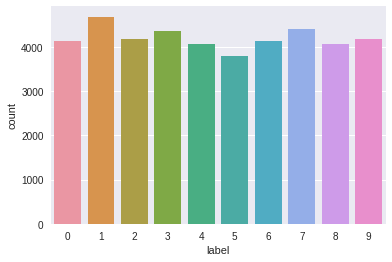

In [8]:
df = pd.read_csv('data/train.csv')
X, y = df[[col for col in df.columns if col != 'label']], df['label']
X = X/256
sns.countplot(y)
X.info()


###Undersample Data
Balance classes with random undersampler and re-evaluate data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37950 entries, 0 to 37949
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 227.0 MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


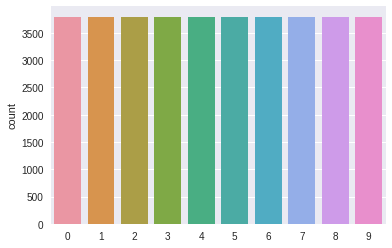

In [9]:
rus = RandomUnderSampler(return_indices=True)
X, y, idx_resample = rus.fit_sample(X,y)
sns.countplot(y)
pd.DataFrame(X).info()

###View Data

6


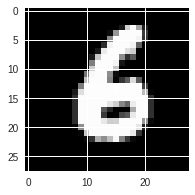

3


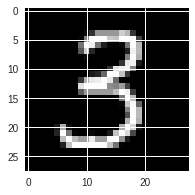

3


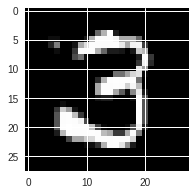

0


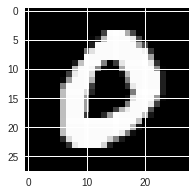

4


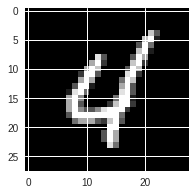

In [10]:
for i in range(0,5):
    idx = random.randint(0, len(y))
    print(y[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(X[idx].reshape(28,28), cmap='gray')
    plt.show()

###Train Test Split
Threeway holdout with 5xCV will be used to tune models to have a strong generalisation accuracy.
Holdout/Unseen data will be used as a sanity check and for detailed comparison.


**Three-Way Holdout With KFold Cross Validation**

<img src=https://www.lucidchart.com/publicSegments/view/5f2fb6b1-bf64-4aa7-8d91-bd9b34025379/image.jpeg width="750">




In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.90, test_size=0.10, 
                                                    stratify=y, shuffle=True)

##3. Hello Sklearn
Modelling first with the SKlearn package to get a flavor for a variety of approaches.

###Models and Search Space
Test a variety of models and configurations to find the models best suited to digit recognition.
Model performance can be very sensative to hyperparameter configuration. A Gridsearch allows for the selection of optimal models within a search space accounting for pairwise parameter interactions. Results are evaluated by model performance, train/predict speeds.



**Pairwise Interactions for Max Features and N_Estimators**

*Optimise parameters together, not seperately*

<img src=https://i.stack.imgur.com/2g3ua.png width="500">


In [0]:
# list of chosen classifiers.
clfs = [NearestCentroid,
        LinearDiscriminantAnalysis, 
        LogisticRegression,
        RandomForestClassifier,
        GradientBoostingClassifier,
        MLPClassifier,
        ]

# dictionary for grid search parameters
param_grids= {
    'NearestCentroid':{
        'metric':['euclidean']
    },
    'LinearDiscriminantAnalysis' : {
        'solver' : ['svd']
    },
    'LogisticRegression':{
         'solver':['liblinear', 'lbfgs'] #Fast solvers for small data.
    },
    'RandomForestClassifier': {
        'criterion' : ['gini'],
        'n_estimators' : [40,50,],    #Few Estimators
        'max_features':[56, 69],      #More Features
    },
    'GradientBoostingClassifier':{
        'n_estimators' : [40,50],     #More Iterations
        'max_features':['sqrt'],      #Less Features
        'subsample':[1]
    },
    'MLPClassifier': {
        'activation' : ['relu',],
        'hidden_layer_sizes' : [(128,64)],
        'solver' : ['adam'],
        'learning_rate' : ['adaptive','constant'],
        'alpha':[0.0001,0.001],
        'early_stopping' : [True],
        'validation_fraction' : [0.1],
        'beta_1':[0.2,0.3],
    },    
}

In [13]:
%%time
results = {}

import sys

#Find top10 Classifiers in a gridsearch.
def topn(gridsearch, n):
  GS_df = pd.DataFrame(gridsearch.cv_results_)
  topn = GS_df.sort_values('mean_test_score',ascending=False).head(n)
  return topn

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    print(clf_name)
    
    #execute gridsearch on classifier
    current_GS = GridSearchCV(clf(), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=False,
                              n_jobs=1,
                              return_train_score=True).fit(X_train, y_train)
    
    #store and filter top10 gridsearch results
    filter_results = ['rank_test_score'  , 
                      'mean_train_score' , 'std_train_score',
                      'mean_test_score'  , 'std_test_score',
                      'mean_fit_time'    , 'std_fit_time', 
                      'mean_score_time'  , 'std_score_time',
                      'params',
                      ]
    top5 = topn(current_GS, 5)[filter_results]
    results[clf_name] = top5
    display(top5.round(3))
    print()

NearestCentroid


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.806,0.001,0.805,0.005,0.184,0.005,0.025,0.002,{'metric': 'euclidean'}



LinearDiscriminantAnalysis


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.876,0.001,0.862,0.004,7.303,0.093,0.017,0.0,{'solver': 'svd'}



LogisticRegression


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.933,0.001,0.913,0.004,61.533,2.776,0.018,0.001,{'solver': 'liblinear'}
1,2,0.933,0.001,0.913,0.004,47.586,0.230,0.018,0.001,{'solver': 'lbfgs'}



RandomForestClassifier


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
1,1,1.0,0.0,0.962,0.002,22.279,0.227,0.115,0.011,"{'criterion': 'gini', 'max_features': 56, 'n_e..."
3,2,1.0,0.0,0.961,0.003,26.374,0.314,0.101,0.011,"{'criterion': 'gini', 'max_features': 69, 'n_e..."
0,3,1.0,0.0,0.960,0.002,17.588,0.218,0.089,0.007,"{'criterion': 'gini', 'max_features': 56, 'n_e..."
2,4,1.0,0.0,0.960,0.002,21.383,0.400,0.085,0.004,"{'criterion': 'gini', 'max_features': 69, 'n_e..."



GradientBoostingClassifier


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
1,1,0.923,0.001,0.910,0.004,56.569,1.260,0.160,0.016,"{'max_features': 'sqrt', 'n_estimators': 50, '..."
0,2,0.913,0.001,0.902,0.004,46.224,1.855,0.121,0.014,"{'max_features': 'sqrt', 'n_estimators': 40, '..."



MLPClassifier


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
6,1,0.992,0.005,0.969,0.002,21.110,8.736,0.053,0.001,"{'activation': 'relu', 'alpha': 0.001, 'beta_1..."
2,2,0.993,0.002,0.968,0.004,18.333,2.118,0.054,0.001,"{'activation': 'relu', 'alpha': 0.0001, 'beta_..."
1,3,0.991,0.005,0.968,0.004,18.244,5.587,0.053,0.001,"{'activation': 'relu', 'alpha': 0.0001, 'beta_..."
5,4,0.992,0.003,0.968,0.003,18.277,4.763,0.054,0.002,"{'activation': 'relu', 'alpha': 0.001, 'beta_1..."
7,5,0.989,0.005,0.968,0.003,16.856,6.145,0.054,0.002,"{'activation': 'relu', 'alpha': 0.001, 'beta_1..."



CPU times: user 1h 21min 52s, sys: 10min 3s, total: 1h 31min 55s
Wall time: 1h 4min 47s


###Select Paramameters
Choose desirable models and configurations for further testing.
Check if there are common settings in the top model configurations. e.g. large ensembles, small learning rates etc.

In [22]:
#Common Settings for best performers
top5_params = {k:v.params for k,v in results.items()}

#settings with highest accuracy
selected_params = {k:v.params.values[0] for k,v in results.items()}

print('Selected Params:')
for k,v in top5_params.items():
  print(k)
  display(pd.DataFrame(list(v)).head(1))
  print()

print('Top5 Params')
for k,v in top5_params.items():
  print(k)
  display(pd.DataFrame(list(v)))
  print()

#costom settings from results table
# selected_params = {
#     'NearestCentroid':0
#     ...    
#}


Selected Params:
NearestCentroid


,metric
0,euclidean



LinearDiscriminantAnalysis


,solver
0,svd



LogisticRegression


,solver
0,liblinear



RandomForestClassifier


,criterion,max_features,n_estimators
0,gini,56,50



GradientBoostingClassifier


,max_features,n_estimators,subsample
0,sqrt,50,1



MLPClassifier


,activation,alpha,beta_1,early_stopping,hidden_layer_sizes,learning_rate,solver,validation_fraction
0,relu,0.001,0.3,True,"(128, 64)",adaptive,adam,0.1



Top5 Params
NearestCentroid


,metric
0,euclidean



LinearDiscriminantAnalysis


,solver
0,svd



LogisticRegression


,solver
0,liblinear
1,lbfgs



RandomForestClassifier


,criterion,max_features,n_estimators
0,gini,56,50
1,gini,69,50
2,gini,56,40
3,gini,69,40



GradientBoostingClassifier


,max_features,n_estimators,subsample
0,sqrt,50,1
1,sqrt,40,1



MLPClassifier


,activation,alpha,beta_1,early_stopping,hidden_layer_sizes,learning_rate,solver,validation_fraction
0,relu,0.0010,0.3,True,"(128, 64)",adaptive,adam,0.1
1,relu,0.0001,0.3,True,"(128, 64)",adaptive,adam,0.1
2,relu,0.0001,0.2,True,"(128, 64)",constant,adam,0.1
3,relu,0.0010,0.2,True,"(128, 64)",constant,adam,0.1
4,relu,0.0010,0.3,True,"(128, 64)",constant,adam,0.1


###10xCV Experiment
More stable than a standard Train-Test split; a robust metric.

In [23]:
%%time

# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(clf(**params), 
                                                  X_train, y_train,
                                                  cv=cv_experiment_folds,
                                                  n_jobs=1,
                                                  verbose=False)) 

# print the avg CVx10 score.
# Do ranked cross val
cv_results = pd.DataFrame(cv_scores, ['10xCV']).round(3).T
display(cv_results)

,10xCV
GradientBoostingClassifier,0.912
LinearDiscriminantAnalysis,0.862
LogisticRegression,0.914
MLPClassifier,0.966
NearestCentroid,0.805
RandomForestClassifier,0.961


CPU times: user 29min 14s, sys: 1min 13s, total: 30min 28s
Wall time: 27min 1s


### Learning Curves Experiment
Assess models capacities for further learning and evaluated bias/variance tradeoffs.
Models may be in a receding phase for its generalisationa accuracy; or near the "knee" of the curve where they could greatly benefit from more data.

![Learning Curve Signatures](https://sebastianraschka.com/images/faq/ml-solvable/bias-variance.png)








CPU times: user 1h 1min 57s, sys: 3min 9s, total: 1h 5min 6s
Wall time: 56min 31s


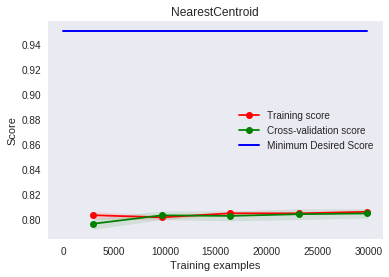

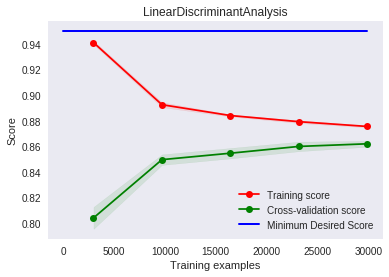

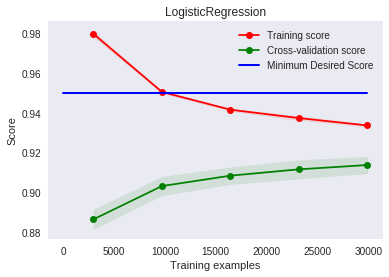

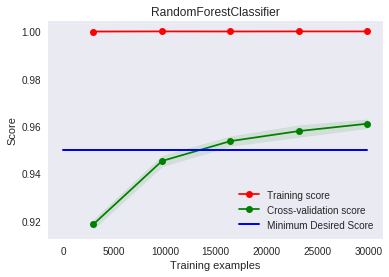

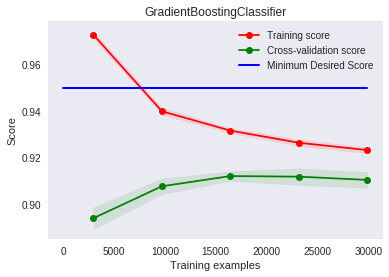

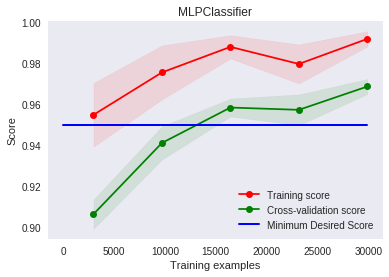

In [24]:
%%time

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=1, train_sizes=np.linspace(.1,1.0,5), 
                       acc_threshold=0.95):
    #plot Setup
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    #unpack plot data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_std, test_std = [np.std(A, axis=1) for A in [train_scores, test_scores]]
    train_mean, test_mean = [np.mean(A, axis=1) for A in [train_scores, test_scores]]

    plt.grid()
    
    #overlay std_dev on train curve
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    
    #overlay std_dev on validation curve
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    
    #plot train points
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    
    #plot validation points
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    #plot accuracy threshold
    plt.plot([0, train_sizes[-1]], [acc_threshold]*2, 'k-',color='b', lw=2, 
             label="Minimum Desired Score")

    plt.legend(loc="best")
    #return plt
  
for clf in clfs:
  clf_name = str(clf).split(".")[-1][:-2]
  clf_params = selected_params[clf_name]
  plot_learning_curve(clf(**clf_params), clf_name, 
                      X_train, y_train, 
                      cv=learning_curve_folds) 

###Holdout Experiment
Construct classification reoports for each model using holdout data. Each report indicates the models strengths and weaknesses. Largest bars are for strongest classes; no bar is the weakest,

In [30]:
%%time

def pandas_classification_report(y_test, y_pred):
    #grab summary
    metrics_summary = precision_recall_fscore_support(y_test, y_pred)
    
    #grab avg
    avg = list(precision_recall_fscore_support(y_test, y_pred, 
                                               average='weighted'))

    #setup dataframe of cols<-labels, rows<-scores
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    #sum support and assign it to average
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    #add avg/total column
    class_report_df['avg / total'] = avg

    #transpose reusult cols<-scores, rows <- labels
    return class_report_df.T

holdout_scores={}
clf_reports={}

for clf in clfs:
  clf_name = str(clf).split(".")[-1][:-2]
  clf_params = selected_params[clf_name]
  
  #define and fit model;
  model = clf(**clf_params)
  model.fit(X_train, y_train)
  joblib.dump(model, clf_name+'.pkl')
  
  #Make predicitons
  preds = model.predict(X_test)
  
  #Make classification report
  print(clf_name)
  clf_report = pandas_classification_report(y_test, preds) 
  clf_reports[clf_name] = clf_report
  display(clf_report.\
          round(3).\
          style.\
          bar(subset=['precision', 'recall', 'f1-score'], 
              align='left', 
              color='#5fba7d'))
  print()
  
  #Create and store accuracy scores
  score = accuracy_score(preds, y_test)
  holdout_scores[clf_name] = score


#format and display holdout results
holdout_results = pd.DataFrame(holdout_scores, ['Holdout_Acc']).round(3).T
display(holdout_results)



NearestCentroid


,precision,recall,f1-score,support
0,0.906,0.863,0.884,380
1,0.738,0.955,0.833,380
2,0.865,0.779,0.82,380
3,0.748,0.75,0.749,380
4,0.787,0.821,0.804,379
5,0.733,0.681,0.706,379
6,0.895,0.881,0.888,379
7,0.903,0.858,0.88,380
8,0.813,0.747,0.779,379
9,0.746,0.765,0.755,379



LinearDiscriminantAnalysis


,precision,recall,f1-score,support
0,0.939,0.937,0.938,380
1,0.864,0.955,0.908,380
2,0.919,0.839,0.878,380
3,0.846,0.839,0.843,380
4,0.849,0.921,0.884,379
5,0.825,0.821,0.823,379
6,0.927,0.91,0.919,379
7,0.91,0.821,0.863,380
8,0.826,0.789,0.807,379
9,0.791,0.85,0.819,379



LogisticRegression


,precision,recall,f1-score,support
0,0.953,0.963,0.958,380
1,0.944,0.984,0.964,380
2,0.912,0.9,0.906,380
3,0.883,0.897,0.89,380
4,0.924,0.929,0.926,379
5,0.876,0.855,0.865,379
6,0.938,0.96,0.949,379
7,0.94,0.942,0.941,380
8,0.918,0.858,0.887,379
9,0.879,0.881,0.88,379



RandomForestClassifier


,precision,recall,f1-score,support
0,0.969,0.984,0.977,380
1,0.979,0.987,0.983,380
2,0.942,0.982,0.961,380
3,0.965,0.934,0.949,380
4,0.968,0.968,0.968,379
5,0.953,0.958,0.955,379
6,0.976,0.982,0.979,379
7,0.968,0.947,0.957,380
8,0.968,0.96,0.964,379
9,0.962,0.947,0.955,379



GradientBoostingClassifier


,precision,recall,f1-score,support
0,0.946,0.966,0.956,380
1,0.951,0.974,0.962,380
2,0.924,0.926,0.925,380
3,0.892,0.866,0.879,380
4,0.913,0.918,0.916,379
5,0.902,0.879,0.89,379
6,0.948,0.955,0.951,379
7,0.932,0.905,0.919,380
8,0.905,0.902,0.904,379
9,0.859,0.881,0.87,379



MLPClassifier


,precision,recall,f1-score,support
0,0.974,0.982,0.978,380
1,0.979,0.979,0.979,380
2,0.969,0.971,0.97,380
3,0.944,0.968,0.956,380
4,0.971,0.974,0.972,379
5,0.978,0.939,0.958,379
6,0.979,0.976,0.978,379
7,0.949,0.979,0.964,380
8,0.976,0.96,0.968,379
9,0.968,0.955,0.961,379


,Holdout_Acc
GradientBoostingClassifier,0.917
LinearDiscriminantAnalysis,0.868
LogisticRegression,0.917
MLPClassifier,0.968
NearestCentroid,0.810
RandomForestClassifier,0.965


CPU times: user 3min 13s, sys: 7.21 s, total: 3min 20s
Wall time: 2min 59s


###Best Vs. Rest
Compare all classifiers to "best" to analyse subtle performance differences for each class and their unique strengths if any. Where the best imprvoes on a measurement, bar will be green and rightward. Where "best" is outperformed in a certain category, it will be measured in red, and leftward.


In [31]:
#Best choice from 10xCV
best_guess = cv_results['10xCV'].idxmax()

#Best choice from holdout
#Best_guess = holdout_results['Holdout_Acc'].idxmax()

#Custom choice
#best_guess='MLPClassifier'

best = clf_reports[best_guess]

print('Best 10xCV CLF:',best_guess, end='\n\n')
for name,report in clf_reports.items():
  if name==best_guess:
    continue
  print(name,'vs',best_guess)
  display((best - report).round(3).style.bar(
      subset=['precision', 'recall', 'f1-score'], 
      align='zero', 
      color=['#d65f5f', '#5fba7d']))
  print()

Best 10xCV CLF: MLPClassifier

NearestCentroid vs MLPClassifier


,precision,recall,f1-score,support
0,0.068,0.118,0.094,0
1,0.241,0.024,0.146,0
2,0.103,0.192,0.15,0
3,0.196,0.218,0.207,0
4,0.184,0.153,0.169,0
5,0.245,0.259,0.252,0
6,0.083,0.095,0.089,0
7,0.046,0.121,0.084,0
8,0.163,0.214,0.19,0
9,0.222,0.19,0.206,0



LinearDiscriminantAnalysis vs MLPClassifier


,precision,recall,f1-score,support
0,0.035,0.045,0.04,0
1,0.115,0.024,0.071,0
2,0.049,0.132,0.092,0
3,0.097,0.129,0.113,0
4,0.122,0.053,0.089,0
5,0.153,0.119,0.136,0
6,0.051,0.066,0.059,0
7,0.039,0.158,0.101,0
8,0.15,0.172,0.161,0
9,0.177,0.106,0.142,0



LogisticRegression vs MLPClassifier


,precision,recall,f1-score,support
0,0.021,0.018,0.02,0
1,0.035,-0.005,0.015,0
2,0.057,0.071,0.064,0
3,0.06,0.071,0.066,0
4,0.047,0.045,0.046,0
5,0.102,0.084,0.093,0
6,0.041,0.016,0.028,0
7,0.009,0.037,0.023,0
8,0.058,0.103,0.081,0
9,0.089,0.074,0.081,0



RandomForestClassifier vs MLPClassifier


,precision,recall,f1-score,support
0,0.005,-0.003,0.001,0
1,-0,-0.008,-0.004,0
2,0.027,-0.011,0.008,0
3,-0.021,0.034,0.007,0
4,0.003,0.005,0.004,0
5,0.025,-0.018,0.003,0
6,0.002,-0.005,-0.001,0
7,-0.019,0.032,0.006,0
8,0.008,0,0.004,0
9,0.005,0.008,0.007,0



GradientBoostingClassifier vs MLPClassifier


,precision,recall,f1-score,support
0,0.028,0.016,0.022,0
1,0.028,0.005,0.017,0
2,0.045,0.045,0.045,0
3,0.052,0.103,0.077,0
4,0.058,0.055,0.057,0
5,0.076,0.061,0.068,0
6,0.031,0.021,0.026,0
7,0.017,0.074,0.045,0
8,0.071,0.058,0.065,0
9,0.109,0.074,0.092,0


##4.  Deploy

###Load Kaggle Data and Model
Kaggle evaluates submissions by supplying the user with unlabeled test data. Predictions on unseen data are evaluated by Kaggle and fedback to the user.


In [0]:
test = pd.read_csv('data/test.csv')
top_model = joblib.load(best_guess+'.pkl')

#Re-train with all data
#top_model.fit(X,y)

###Make Prediction File
Format submission to match kaggle specifications.

In [33]:
#Make Predictions and cast as DataFrame
preds = top_model.predict(test)
preds = pd.DataFrame(preds, columns=['Label'])

#Add Image IDs, and re-order columns
preds['ImageID'] = range(1,len(preds)+1)
preds = preds[['ImageID','Label']]

#Save as CSV
pd.DataFrame(preds).to_csv('digit_recognition_sub.csv', index=False)

#Verify Raw File
! head digit_recognition_sub.csv

ImageID,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


###Download Prediction File

In [0]:
from google.colab import files

files.download('digit_recognition_sub.csv')
files.download(best_guess+'.pkl')

###Upload Predictions
1. [Digit Recognizer Submission](https://www.kaggle.com/c/digit-recognizer/submit): Drag and drop digit_recognition_sub.csv from downloads folder into submission box.
2. Fill describe model and submission!
3. Submit; check out score on the LeaderBoard:
96%+

###Results
MLP and RandomForest are strong learners for MNist problem. 

*   Where RF learns very quickly levels off just over the 95% mark. 
*   The MLP has a slower rate to start, but surpasses RF and still appears to have potential for further leaerning. If the size of the traintest split; were altered; the MLP could likely break 97%.

* Nueral Nets have a strong ability to learn high level representatons for problems such as MNist; however the simple architecture used can be enhanced.

In the next iteration the Keras package will be used to explore different Nueral Net architectures and how well they generalise to the task of digit recornition.

## 4. Hello Documentation

### Package Overview
The advantage with many open-source packages is that they are well supported and typically well documented and tested. The Google client has less clear documentation but has generally good support on Stack-OverFlow and in Colaboratory Tutorials.

[SKLearn](http://scikit-learn.org/stable/index.html) : A simple open source machine learning toolkit in Python.

[Kaggle](https://www.kaggle.com/) : Hosts the data sources that will be used.

[Kaggle API](https://github.com/Kaggle/kaggle-api/blob/master/README.md) : CLI to engage with Kaggle.

[Google Client API](https://developers.google.com/drive/v3/web/quickstart/python): Python REST API for Google Drives.

[Imbalanced Learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/) :  Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.

[Pandas](https://pandas.pydata.org/): Open source data analysis tools for Python

[Seaborn](https://seaborn.pydata.org/): Statistical data visualisation.

[NumPy](http://www.numpy.org/): High performing Python wrapper for C.

[Pandas.style](https://pandas.pydata.org/pandas-docs/stable/style.html): DataFrame styling and graphics in Pandas.